Monthly car sales in Quebec 1960-1968

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [111]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [112]:
cars_df = pd.read_csv("data/car_sales/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Remove last row

In [113]:
cars_df = cars_df.iloc[:-1]

Let's change it into datetime format for nicer plots.

In [114]:
cars_df["dt"] = pd.to_datetime(cars_df["Month"])

Rename the long name in column `Monthly car sales in Quebec 1960-1968` for just `sales`.

In [115]:
cars_df = cars_df.rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)
cars_df.tail()

,Month,sales,dt
103,1968-08,16722.0,1968-08-01
104,1968-09,14385.0,1968-09-01
105,1968-10,21342.0,1968-10-01
106,1968-11,17180.0,1968-11-01
107,1968-12,14577.0,1968-12-01


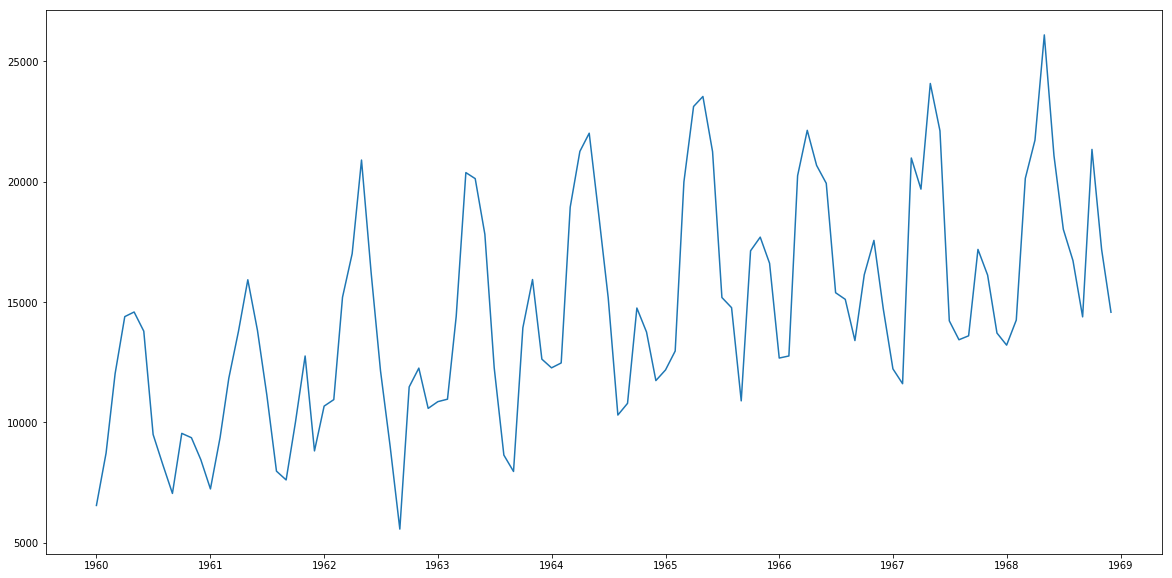

In [116]:
plt.plot(cars_df["dt"], cars_df["sales"])
plt.show()

Let's check if there is no missing data. For example, let's check if each year has 12 months.

In [117]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Train - dev - test split

Here we cannont do random spliting later we will explain why. Our split should be based on time.

In [118]:
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Simplest prediction: average of previous sales

In [119]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

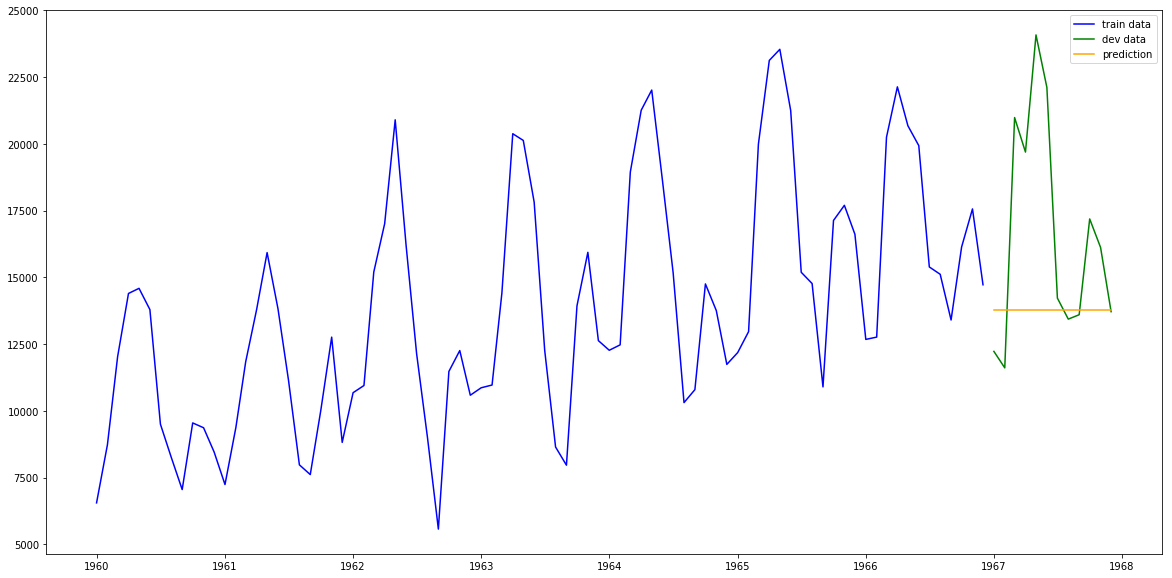

In [120]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We see that this is not very good prediction. However, we will use it as our __baseline__, that is a starting point for further improvments. For that let's calculate mean square error (MSE) and root of mean square error (RMSE) which will serve us for comparation with better predictions.

In [121]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_dev, y_dev_hat), np.sqrt(mean_squared_error(y_dev, y_dev_hat))

(23847172.57993197, 4883.356691859808)

## Average of the previous year

So let's take the last 12 values and calculate mean.

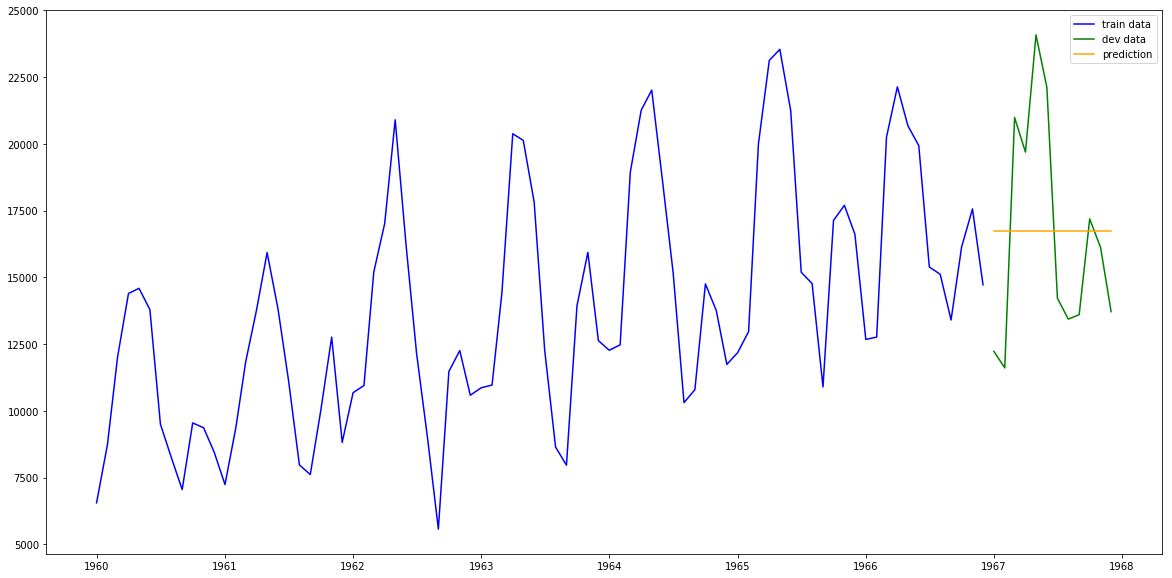

In [122]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

This time it looks better.

In [123]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

So we have also improved RMSE.

## Taking advantage of knowing previous month

Often, we know the value for the previous month and we want to predict just the next month. For this we add to our feature set $X$ the value of the prevous month. For that we have python method `shift`.

In [124]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0
3,1960-04-01,14395.0,12026.0
4,1960-05-01,14587.0,14395.0


In [125]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

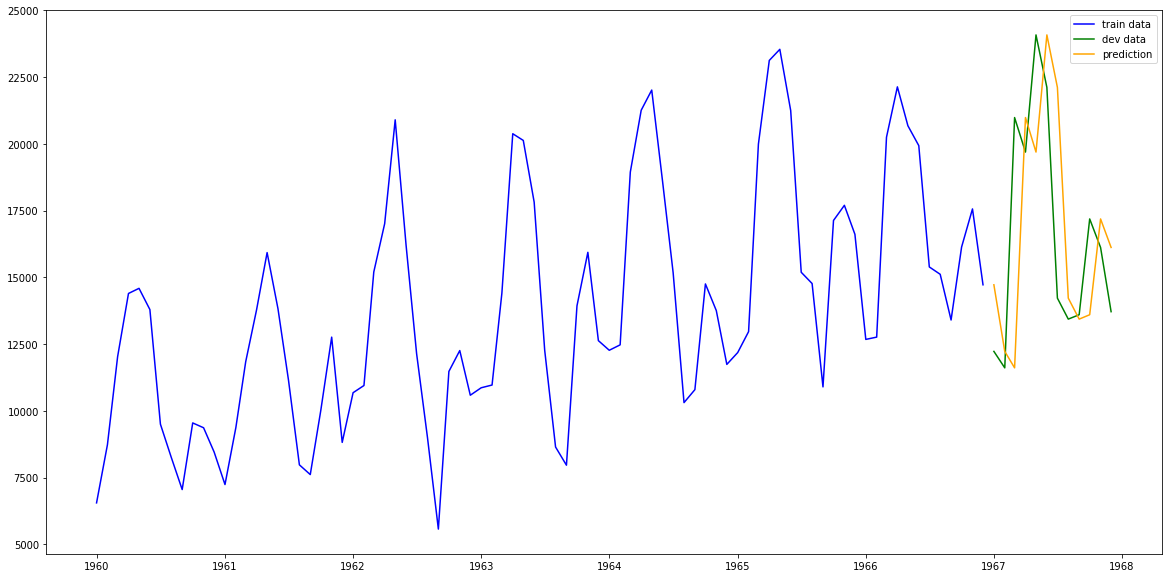

In [126]:
y_dev_hat = X_dev['sales-1']
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [127]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

## Moving Window

Instead of calculating average of last 12 months, we can move a window among last 12 months and calculate it. 

In [ ]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

Now let's add previous 12 months.

In [129]:
for i in range(1, 13):
    Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
Xy_with_lags.tail()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
103,1968-08-01,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0,13434.0
104,1968-09-01,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0,13598.0
105,1968-10-01,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0,17187.0
106,1968-11-01,17180.0,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0,16119.0
107,1968-12-01,14577.0,17180.0,21342.0,14385.0,16722.0,18024.0,21084.0,26099.0,21725.0,20139.0,14251.0,13210.0,13713.0


In [130]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

Let's take its mean. This is called __moving average__.

In [131]:
columns_for_mean = ["sales-" + str(i) for i in range(1, 13)]
y_dev_hat = X_dev[columns_for_ar].mean(axis=1)

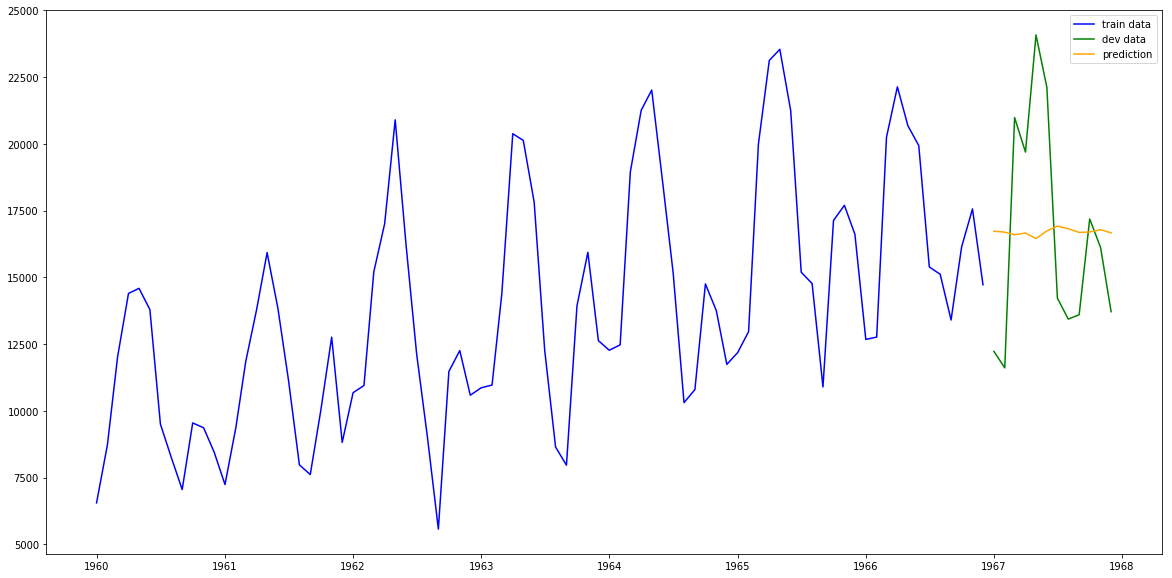

In [132]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [133]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4076.0106450249227

## Auto Regression (AR)

At the begning of our dataser we have lots of `NaN`s. Let's remove them.

In [135]:
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1960-01-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
Xy_with_lags = Xy_with_lags.query("dt > '1961'").reset_index(drop=True)
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
1,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
2,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
3,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0
4,1961-06-01,13821.0,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0


In [262]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
columns_for_ar = ["sales-" + str(i) for i in range(1, 13)]

reg.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = reg.predict(X_dev.drop("dt", axis=1))
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1998.6061539258658

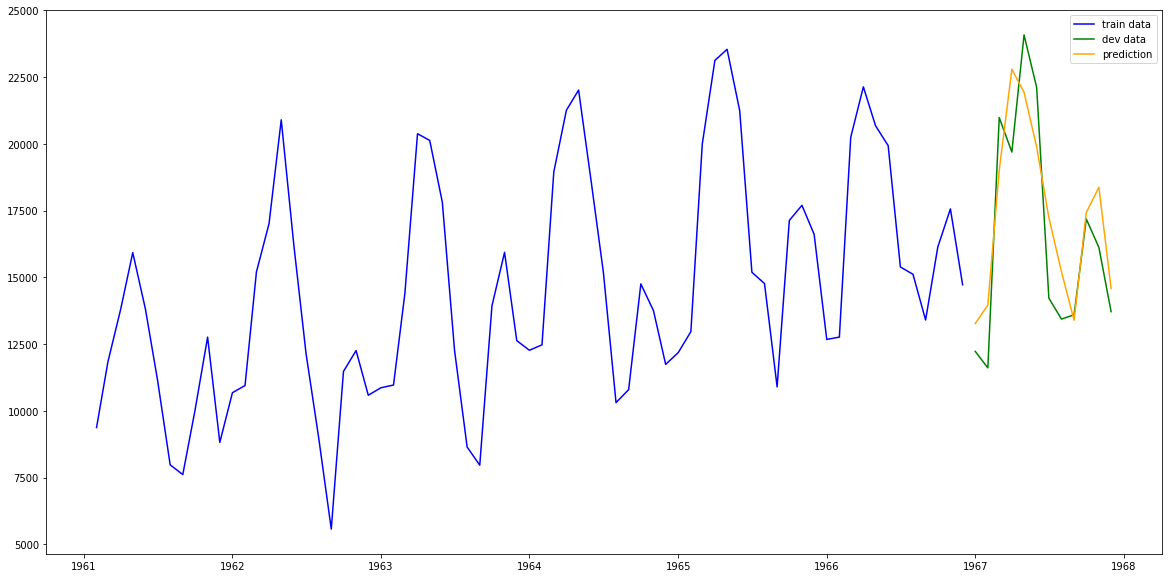

In [263]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

We have improved the performance twice!

However very often in practice we would like to predit the sales for entire year. So let's assume that we are in January 1967 and what to forecast our sales for 1967 monthly. This way the company would know how to optimes stocks for each month. However, this means that when we predict the value for April we do not know what is real value for January, February and March. So what we will predict the sales for January and than use this as a feature for predicting February. And so on. Let's see how we are going to program that.

In [266]:
x_dev = list(y_train[-1:-13:-1])
y_dev_hat = []
for i in range(12):
    y_hat = reg.predict([x_dev])[0]
    y_dev_hat.append(y_hat)
    x_dev.pop()
    x_dev = [y_hat] + x_dev
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1887.4895020779702

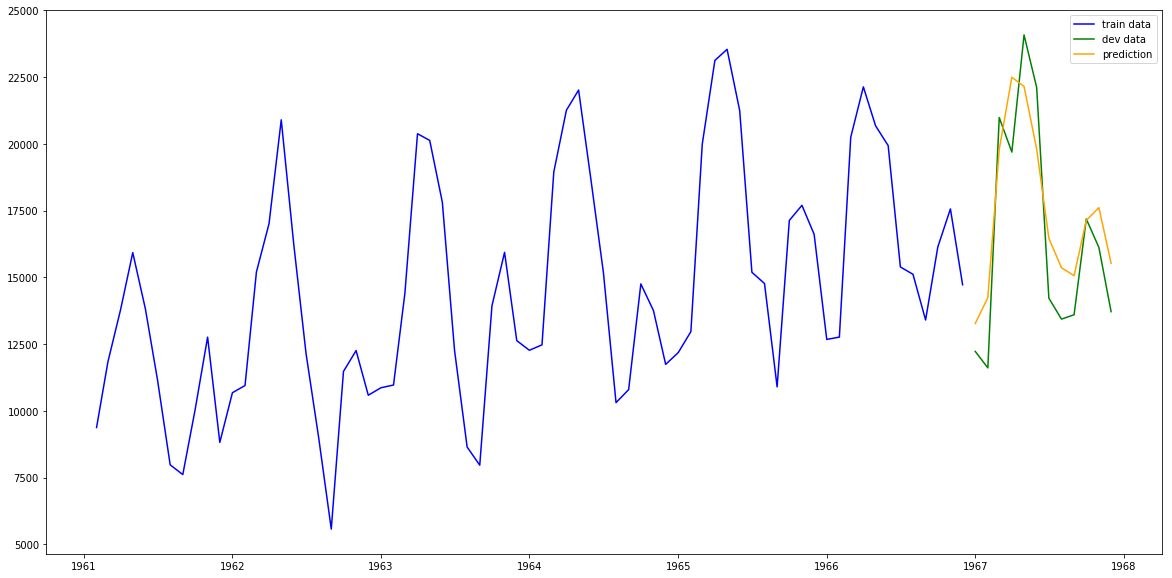

In [267]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

## Sesonality adjustment

In [356]:
Xy_with_lags["year_diff"] = Xy_with_lags["sales"] - Xy_with_lags["sales-12"] 

In [289]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1782.126907877626


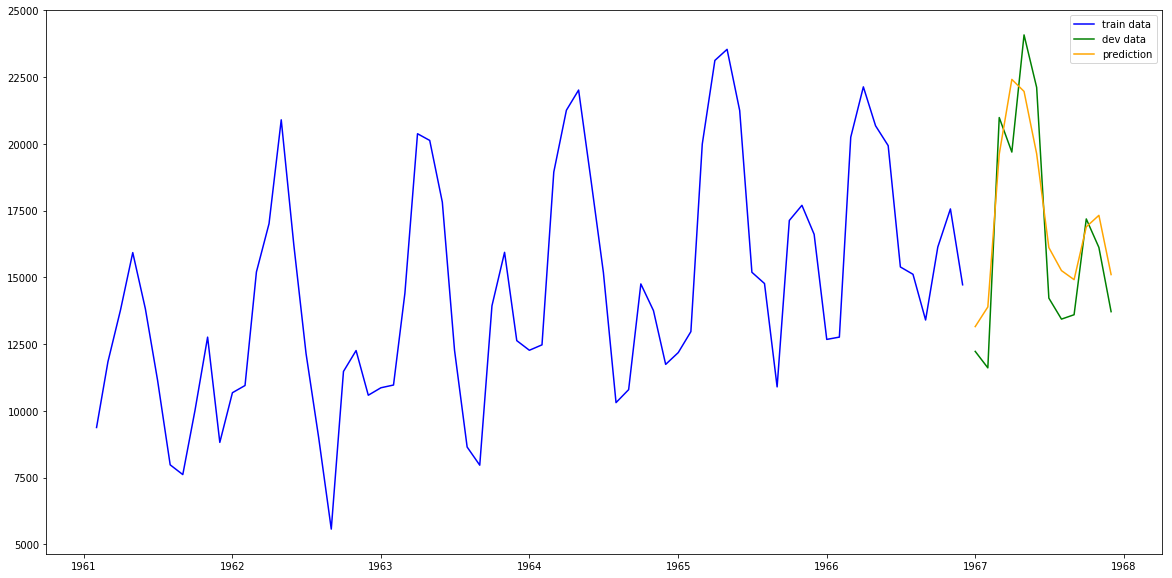

In [290]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [288]:
model_fit = model.fit(maxlag=13)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1717.5425285941851


## Moving Agerage (MA)

In [351]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [350]:
for p in range(12):
    for d in range(12):

        try:
            arima_mod=ARMA(y_train,(p,d)).fit(transparams=True)

            x=arima_mod.aic

            x1= p,d
            print (x1,x)

            aic.append(x)
            pdq.append(x1)
        except:
            pass
            # ignore the error and go on


(0, 0) 1389.9956591610353
(0, 1) 1349.7760059643595
(0, 5) 1329.6566151537884


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 7) 1329.5548558512914
(0, 8) 1327.732016133393
(1, 0) 1345.0560961493916
(1, 1) 1337.8405824392826
(1, 2) 1331.3973192409856
(1, 3) 1336.820968883233
(1, 4) 1330.5076155636827
(1, 5) 1343.2103488011362
(1, 6) 1345.2193840700518


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(1, 7) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(1, 8) 1320.145901342951
(1, 11) 1324.558277403693
(2, 0) 1331.6238354802178
(2, 1) 1333.3612226551013
(2, 2) 1327.5319732656349
(2, 3) 1342.4042766802336
(3, 0) 1333.0434605375767
(3, 1) 1359.28211287343


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/E

(3, 3) nan
(4, 0) 1330.0469955664573
(4, 2) 1316.0635851541808
(4, 3) nan
(5, 0) 1331.53765029649
(5, 2) nan
(6, 0) 1327.672808389306
(6, 2) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


(7, 0) 1328.9210658834688
(7, 7) nan
(8, 0) 1330.8235649519124
(9, 0) 1327.5883281342867
(9, 2) 1298.5979301201867
(10, 0) 1314.494466669083
(10, 2) nan
(11, 0) 1300.5525194668378
(11, 1) 1299.2792984898506


In [353]:
for p in range(12):
    for d in range(6):
        for q in range(6):
            try:
                arima_mod=ARIMA(y_train,(p,d,q)).fit(transparams=True)

                x=arima_mod.aic

                x1= p,d,q
                print (x1,x)

                aic.append(x)
                pdq.append(x1)
            except:
                pass
                # ignore the error and go on


(0, 0, 0) 1389.9956591610353
(0, 0, 1) 1349.7760059643595
(0, 0, 5) 1329.6566151537884
(0, 1, 0) 1335.1897041240618
(0, 1, 1) 1332.6959063684424
(0, 1, 2) 1333.4885475010467
(0, 1, 3) 1314.1043954601785
(0, 1, 4) 1309.7155037855882


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 1, 5) 1303.370812896919
(0, 2, 0) 1346.1014518278744
(0, 2, 1) 1323.3160051986943
(0, 2, 2) 1320.433265805742
(0, 2, 3) nan
(1, 0, 0) 1345.0560961493916


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(1, 0, 1) 1337.8405824392826
(1, 0, 2) 1331.3973192409856
(1, 0, 3) 1336.820968883233
(1, 0, 4) 1330.5076155636827
(1, 0, 5) 1343.2103488011362
(1, 1, 0) 1333.3756083943595
(1, 1, 2) 1320.0100031255229
(1, 1, 3) 1313.8874844817622
(1, 1, 4) 1310.6167994542125
(1, 1, 5) 1300.802817955562
(1, 2, 0) 1343.6993250136757
(1, 2, 2) 1322.353187259124
(1, 2, 4) 1305.1066822624566
(2, 0, 0) 1331.6238354802178
(2, 0, 1) 1333.3612226551013
(2, 0, 2) 1327.5319732656349
(2, 0, 3) 1342.4042766802336
(2, 1, 0) 1332.2376699477336


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:632: RuntimeWarning: invalid value encountered in double_scalars
  (1-a**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: divide by zero encountered in true_divide
  invarcoefs = -np.log((1-params)/(1+params))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: di

(2, 1, 4) nan
(2, 1, 5) nan
(2, 2, 0) 1345.167617701505
(2, 2, 2) 1302.339688055238
(2, 2, 4) 1298.7248802612053
(3, 0, 0) 1333.0434605375767


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()


(3, 0, 1) 1359.28211287343


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]


(3, 0, 3) nan
(3, 1, 0) 1319.0576443315788


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(3, 1, 4) 1298.63447573697
(3, 1, 5) 1297.8803821092872
(3, 2, 0) 1336.2505004367106


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


(3, 2, 3) nan


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: divide by zero encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


(3, 2, 4) nan
(4, 0, 0) 1330.0469955664573
(4, 0, 2) 1316.0635851541808
(4, 0, 3) nan
(4, 1, 0) 1318.2266695334422
(4, 1, 1) 1309.5578044064268
(4, 1, 3) nan
(4, 2, 0) 1317.6936413904732
(4, 2, 1) 1307.575471912422
(4, 2, 2) nan
(4, 2, 4) nan
(5, 0, 0) 1331.53765029649
(5, 0, 2) nan
(5, 1, 0) 1318.431212189866
(5, 1, 4) nan
(5, 2, 0) 1317.528456041712
(5, 2, 1) 1307.4636409581858
(5, 2, 2) nan
(6, 0, 0) 1327.672808389306
(6, 0, 2) nan
(6, 1, 0) 1320.0877018158942
(6, 2, 0) 1319.3490647932813
(6, 2, 1) 1309.2439792669143
(6, 2, 2) nan
(6, 2, 3) nan
(6, 2, 4) nan
(7, 0, 0) 1328.9210658834688
(7, 1, 0) 1319.2763339736669
(7, 2, 0) 1321.2607555771556
(7, 2, 1) 1308.8105456894214
(7, 2, 2) nan
(7, 2, 3) nan
(7, 2, 4) nan
(8, 0, 0) 1330.8235649519124
(8, 1, 0) 1310.7687218162926
(8, 1, 1) 1278.6642187275766
(8, 2, 0) 1323.150533831122
(8, 2, 1) 1301.1398811363806
(8, 2, 2) nan
(8, 2, 3) nan
(9, 0, 0) 1327.5883281342867
(9, 0, 2) 1298.5979301201867
(9, 1, 0) 1293.4045539451063
(9, 1, 1) 1273.

/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


(11, 1, 1) 1260.5695347004591
(11, 2, 1) nan
(11, 2, 4) nan


In [352]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

2134.5112136497632


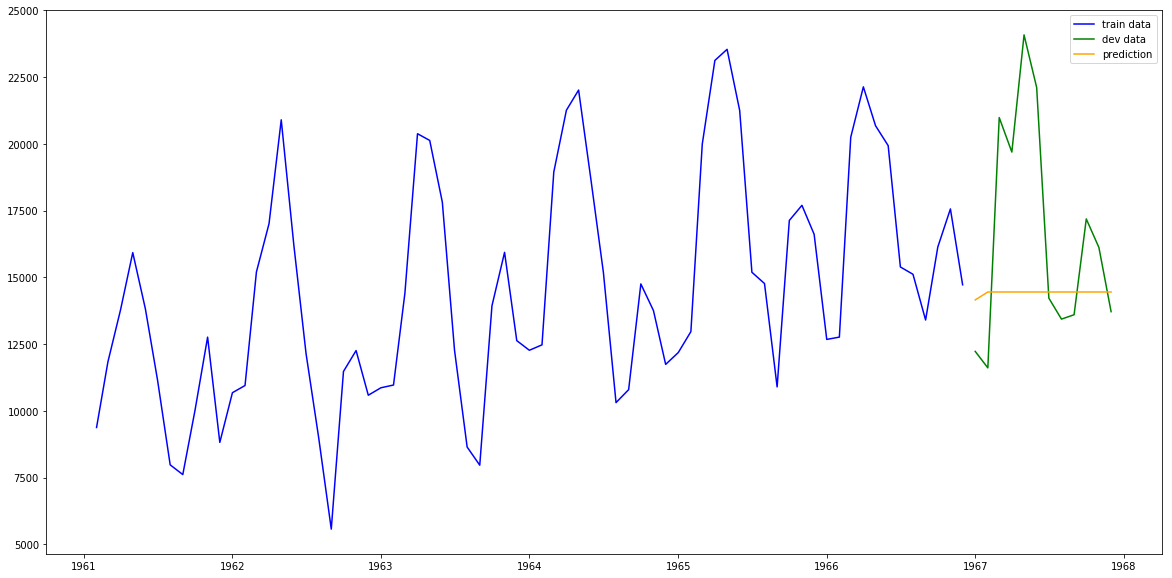

In [338]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

In [332]:
model = ARIMA(y_train, order=(5,1,0))
model_fit = model.fit(disp=0)

In [335]:
y_dev_hat = model_fit.predict(start=len(y_train)-1, end=len(y_train)+11)    
y_dev_hat

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

In [326]:
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1774.487735376506


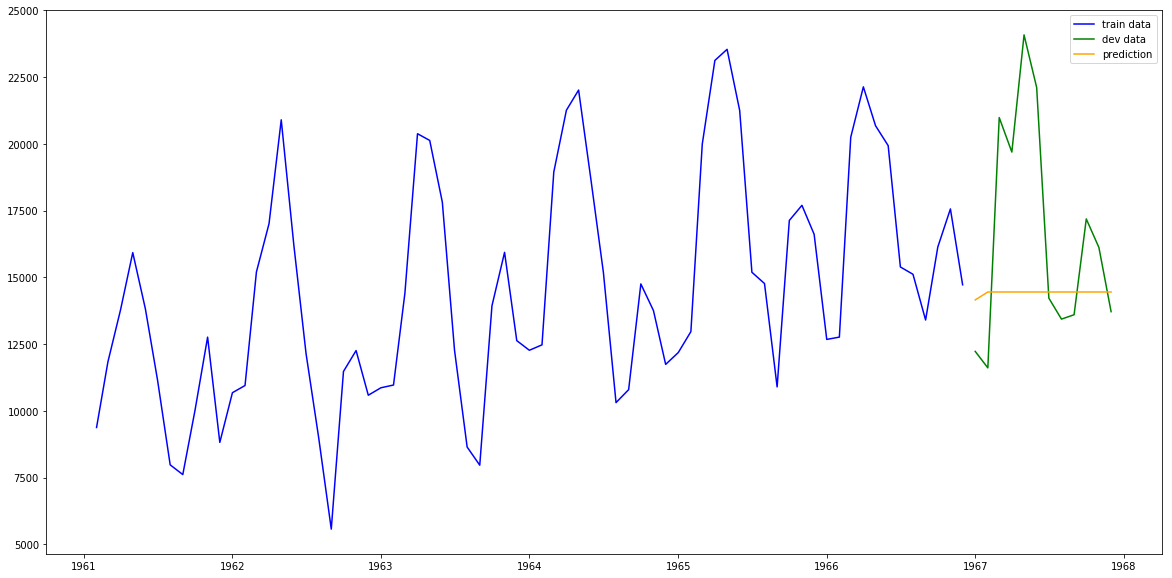

In [299]:
plt.plot(X_train["dt"], y_train, c="blue", label='train data')
plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
plt.legend()
plt.show()

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
